In [1]:
import sys
sys.path.append('../src')

from common import common, transform
from tracker import main as tr
from indivisual_activity import main as ia
from group_activity import main as ga
from display.display import display
import argparse
import os
import cv2
from tqdm import tqdm

In [2]:
room_num = '09'
date = '20210304'
name = 'pass3'
method = 'passing'
THRESHOLD = 0.6

In [3]:
video_path = os.path.join(
    common.data_dir, '{0}/{1}/{2}/AlphaPose_{2}.mp4'.format(room_num, date, name))
out_dir = os.path.join(
    common.out_dir, '{0}/{1}/{2}/'.format(room_num, date, name))
field_path = os.path.join(
    common.data_dir, 'field.png')
keypoints_path = os.path.join(
    common.data_dir, '{0}/{1}/{2}/alphapose-results.json'.format(room_num, date, name))
tracking_json_path = os.path.join(
    common.json_dir, '{0}/{1}/{2}/tracking.json'.format(room_num, date, name))
indivisual_activity_json_path = os.path.join(
    common.json_dir, '{0}/{1}/{2}/indivisual_activity.json'.format(room_num, date, name))
group_activity_json_path = os.path.join(
    common.json_dir, '{0}/{1}/{2}/group_activity.json'.format(room_num, date, name))

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo = transform.Homography(p_video, p_field, field_raw.shape)

In [5]:
# tr.main(keypoints_path, tracking_json_path)

In [6]:
# ia.main(tracking_json_path, indivisual_activity_json_path, homo)

In [7]:
ga.main(
    indivisual_activity_json_path,
    group_activity_json_path,
    homo,
    field_raw,
    method)

In [8]:
# display(
#     video_path,
#     out_dir,
#     indivisual_activity_json_path,
#     group_activity_json_path,
#     field_raw,
#     method)

## 結果をグラフ化する

In [17]:
# 始まり
# 外回り看護師が滅菌パックを開く
# お互いが向いている

# 終わり
# 器械出し看護師が道具を取り出し終わる
# お互いが向き合っていない
manual_result_dict = {
    'pass1': {75: 1, 204: 0, 671: 1, 840: 0, 1080: 1, 1700: 0},
    'pass2': {300: 1, 364: 0, 806: 1, 913: 0, 1242: 1, 1923: 0},
    'pass3': {183: 1, 286: 0, 466: 1, 594: 0, 1130: 1, 1240: 0},
}

person_id_dict = {
    'pass1': [1, 2],
    'pass2': [0, 2],
    'pass3': [1, 2],
}

In [10]:
from common import json
from common.json import GA_FORMAT
from display.video import Video
from display.tracking import disp_tracking
from display.indivisual_activity import disp_indivisual_activity
from display.group_activity import DisplayGroupActivity
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def combine_image(frame, field):
    ratio = 1 - (field.shape[0] - frame.shape[0]) / field.shape[0]
    size = (int(field.shape[1] * ratio), int(field.shape[0] * ratio))
    field = cv2.resize(field, size)
    frame = np.concatenate([frame, field], axis=1)
    return frame

In [12]:
def disp_result(
    combine_image,
    frame_num,
    max_frame_num,
    datas,
    y_pred=[]
):
    json_format = GA_FORMAT['passing']
    
    # フレームご番号までのデータを抜き取る
    datas = [data for data in datas if data[json_format[0]] == frame_num]
    
    # 尤度を取りだす
    for data in datas:
        if (
            data[json_format[2]][0] in person_id_dict[name] and
            data[json_format[2]][1] in person_id_dict[name]
        ):
            y_pred.append(data[json_format[3]])
            break
    else:
        # データがないフレームは0.0を入れる
        y_pred.append(0.0)

    # 手動の結果を作成
    y_true = []
    pre_result = 0
    for i in range(max_frame_num):
        if i in manual_result_dict[name]:
            pre_result = manual_result_dict[name][i]
        y_true.append(pre_result - 0.01)  # 見た目のために0.01引く
    
    # グラフを表示
    width = combine_image.shape[0]
    fig = plt.figure(figsize=(width / 50.0, 4.0))
    ax = fig.add_subplot(
        111,
        xlabel='frame', xlim=(0, max_frame_num),
        ylabel='likelihood', ylim=(0.0, 1.0))
    ax.plot(y_pred)
    ax.plot(y_true)
    ax.axhline(THRESHOLD, color='red')
    plt.close(fig)
    
    # fig to ndarray
    fig.canvas.draw()
    result_image = np.array(fig.canvas.renderer.buffer_rgba())
    result_image = cv2.cvtColor(result_image, cv2.COLOR_RGBA2RGB)
    
    # concat result image
    ratio = 1 - (combine_image.shape[1] - result_image.shape[1]) / combine_image.shape[1]
    size = (int(combine_image.shape[1] * ratio), int(combine_image.shape[0] * ratio))
    combine_image = cv2.resize(combine_image, size)
    frame = np.concatenate([combine_image, result_image], axis=0)
    
    return frame, y_pred

In [18]:
# out video file path
out_path = out_dir + '{}_result.mp4'.format(method)

# load datas
indivisual_activity_datas = json.load(indivisual_activity_json_path)
group_activity_datas = json.load(group_activity_json_path)

display_group_activity = DisplayGroupActivity(group_activity_datas)

# load video
video = Video(video_path)

frames = []
y_pred = []
for frame_num in tqdm(range(video.frame_num)):
    # read frame
    frame = video.read()

    # フレームごとにデータを取得する
    frame_indivisual_activity_datas = [
        data for data in indivisual_activity_datas if data['frame'] == frame_num]

    # フレーム番号を表示
    cv2.putText(frame, 'Frame:{}'.format(frame_num + 1), (10, 50),
                cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))

    field_tmp = field_raw.copy()
    # トラッキングの結果を表示
    frame = disp_tracking(frame_indivisual_activity_datas, frame)
    # 向きを表示
    field_tmp = disp_indivisual_activity(
        frame_indivisual_activity_datas, field_tmp, method)

    group_activity_field = field_tmp.copy()
    group_activity_field = display_group_activity.disp(
        method, frame_num, group_activity_datas, group_activity_field)

    # append tracking result
    img = combine_image(frame, group_activity_field)
    img, y_pred = disp_result(
        img, frame_num, video.frame_num, group_activity_datas[method], y_pred)
    frames.append(img)
    
print('writing videos into {} ...'.format(out_dir))
video.write(frames, out_path, frames[0].shape[1::-1])

100%|██████████| 1302/1302 [01:01<00:00, 21.07it/s]


writing videos into ../out/09/20210304/pass3/ ...


## 混合行列

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [20]:
video = Video(video_path)
max_frame_num = video.frame_num
json_format = GA_FORMAT['passing']

# load data
group_activity_datas = json.load(group_activity_json_path)

# 尤度を取りだす
y_pred = []
for i in range(max_frame_num):
    for data in group_activity_datas[method]:
        if (
            i == data[json_format[0]] and
            data[json_format[2]][0] in person_id_dict[name] and
            data[json_format[2]][1] in person_id_dict[name]
        ):
            likelihood = data[json_format[3]]
            if likelihood > THRESHOLD:
                y_pred.append(1)
            else:
                y_pred.append(0)
            break
    else:
        # データがないフレームは0.0を入れる
        y_pred.append(0)

# 手動の結果を作成
y_true = []
pre_result = 0
for i in range(max_frame_num):
    if i in manual_result_dict[name]:
        pre_result = manual_result_dict[name][i]
    y_true.append(pre_result)

In [21]:
# 混合行列を作成
cm = confusion_matrix(y_true, y_pred)

<AxesSubplot:>

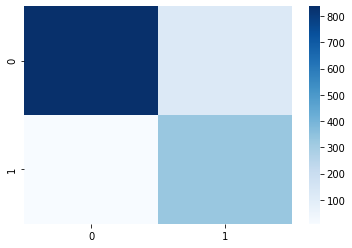

In [22]:
sns.heatmap(cm, cmap='Blues')

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [24]:
print('accuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
print('precision: {:.3f}'.format(precision_score(y_true, y_pred)))
print('recall: {:.3f}'.format(recall_score(y_true, y_pred)))
print('f1: {:.3f}'.format(f1_score(y_true, y_pred)))

accuracy: 0.898
precision: 0.728
recall: 0.974
f1: 0.833
